Loading saved features for orange from orange_features.csv
Loading saved features for green_apple from green_apple_features.csv


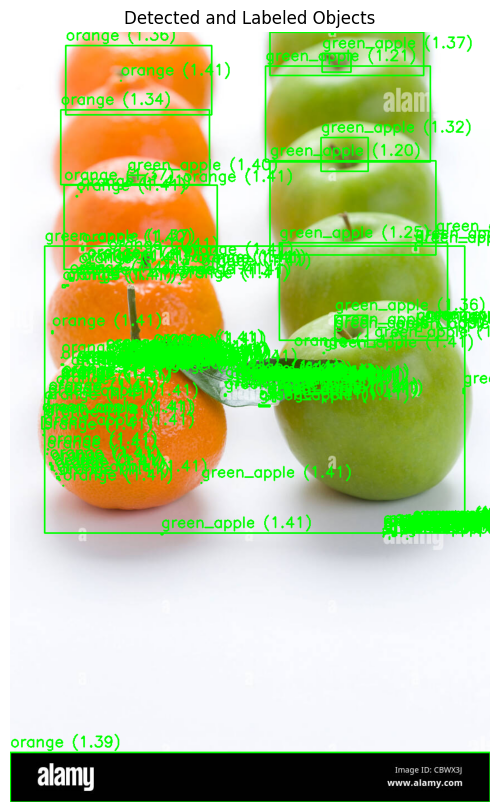

Detected and labeled object saved as detected_image.jpg


In [15]:

import cv2
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import ast
import os

image_path = r"Image.jpeg"
# Step 1: Load the Image (using OpenCV)
def load_image(image_path):
    image = cv2.imread(image_path)
    return image


# Step 2: Convert Image to Grayscale (using OpenCV's built-in function)
def convert_to_grayscale(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return grayscale_image


# Step 3: Display Image using Matplotlib (Optional - for visualization purposes)
def show_image(image, title="Image"):
    if len(image.shape) == 2:  # Grayscale image
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(title)
    plt.axis('off')  # Hide axes
    plt.show()


# Step 4: Segment the Image using Thresholding
def segment_image(image):
    gray = convert_to_grayscale(image)  # Use grayscale conversion directly
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresholded


# Step 5: Extract Features from the Image
def extract_features(image, thresholded):
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = {
        "Area": [],
        "Perimeter": [],
        "Bounding Box": [],
        "Centroid": [],
        "Color Histogram": []
    }

    gray = convert_to_grayscale(image)  # Ensure grayscale for mask generation

    for contour in contours:
        # Shape Features
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        x, y, w, h = cv2.boundingRect(contour)
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Color Features
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        masked_img = cv2.bitwise_and(image, image, mask=mask)
        hist = cv2.calcHist([masked_img], [0, 1, 2], mask, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        # Store features
        features["Area"].append(area)
        features["Perimeter"].append(perimeter)
        features["Bounding Box"].append((x, y, w, h))
        features["Centroid"].append((cX, cY))
        features["Color Histogram"].append(hist.tolist())  # Save as a list to be CSV-compatible

    return pd.DataFrame(features)


# Step 6: Create Reference Feature Set (Safely Parse CSV using ast.literal_eval)
def create_reference_features():
    reference_images = {
        "orange": r"Orange.jpeg",
        "green_apple": r"Green Apples.jpg"
    }
    reference_features = {}

    for label, img_path in reference_images.items():
        features_csv = f"{label}_features.csv"
        if os.path.exists(features_csv):
            print(f"Loading saved features for {label} from {features_csv}")
            reference_features[label] = pd.read_csv(features_csv, converters={"Color Histogram": ast.literal_eval})
        else:
            print(f"Extracting and saving features for {label}")
            image = load_image(img_path)
            if image is None:
                print(f"Error: Image {img_path} not found.")
                continue
            thresholded = segment_image(image)
            features_df = extract_features(image, thresholded)
            features_df.to_csv(features_csv, index=False)
            reference_features[label] = features_df

    return reference_features


# Step 7: Compare Features to Detect Object
def compare_features(reference_features, target_histogram):
    best_match = None
    best_distance = float('inf')

    for label, ref_features_df in reference_features.items():
        for ref_index, ref_row in ref_features_df.iterrows():
            ref_histogram = np.array(ref_row["Color Histogram"])
            dist = distance.euclidean(ref_histogram, target_histogram)

            if dist < best_distance:
                best_distance = dist
                best_match = label

    return best_match, best_distance


# Step 8: Detect and Label Objects Automatically
def detect_and_label_objects(image, thresholded, reference_features):
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)
        bbox = (x, y, w, h)

        # Extract color histogram features from the bounding box
        cropped_image = image[y:y+h, x:x+w]
        mask = np.ones(cropped_image.shape[:2], dtype="uint8") * 255
        hist = cv2.calcHist([cropped_image], [0, 1, 2], mask, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        # Compare features with reference objects (orange, green apple)
        label, similarity_index = compare_features(reference_features, hist)

        # Draw bounding box and label the detected object
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        label_text = f"{label} ({similarity_index:.2f})"
        cv2.putText(image, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image


# Step 9: Main Function to Run the Program
def main():
    # Create reference features for orange and green apple
    reference_features = create_reference_features()

    # Load the target image
    target_image_path = r"Image1.jpg"
    target_image = load_image(target_image_path)

    if target_image is None:
        print(f"Error: Image {target_image_path} not found.")
        return

    # Segment the target image
    thresholded = segment_image(target_image)

    # Detect and label the objects automatically
    labeled_image = detect_and_label_objects(target_image, thresholded, reference_features)

    # Save and display the result
    detected_image_path = r"detected_image.jpg"
    cv2.imwrite(detected_image_path, labeled_image)

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected and Labeled Objects")
    plt.axis('off')
    plt.show()

    print(f"Detected and labeled object saved as {detected_image_path}")


if __name__ == "__main__":
    main()